In [2]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy import signal

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start_time, end_time = "05/12/2021 00:00", "05/12/2021 00:30"
path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/20211205/'

print(f'reading CSV files')
start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

ldf = list()
for p in tqdm(glob.glob(path + "*.csv")):
    name = os.path.split(p)[-1]
    nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
    if start <= nstr < end:
        df_tmp = pd.read_csv(p)
        c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
        if len(c_drop) > 0:
            df_tmp.drop(columns=list(c_drop), inplace=True)
        df_tmp = df_tmp[df_tmp["sens_pos"]== "C1.1.1"]
        ldf.append(df_tmp)
df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
df.reset_index(inplace=True, drop=True)

#df = df[df['sens_pos'].isin(self.sensors)]
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
data = df[df["sens_pos"]== "C1.1.1"]
data["zN"] = data["z"]-np.mean(data["z"])
data["vars"] = data["zN"].rolling(window=10).var().fillna(0)

reading CSV files


100%|██████████| 1450/1450 [00:12<00:00, 113.21it/s]


(0.0, 2e-06)

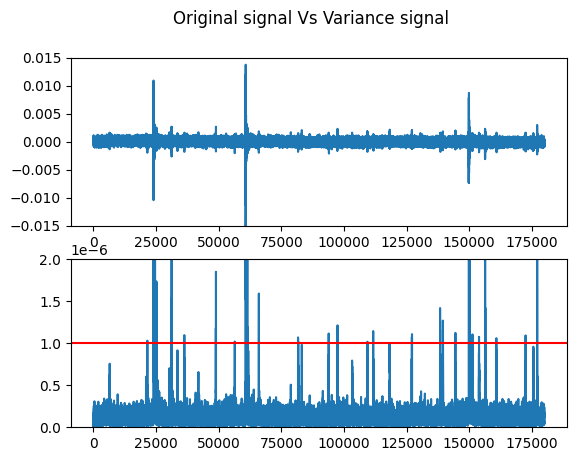

In [4]:
fig, axs = plt.subplots(2)
fig.suptitle('Original signal Vs Variance signal')
axs[0].plot(data["zN"])
axs[0].set_ylim(-0.015, 0.015)
axs[1].plot(data["vars"])
axs[1].axhline(y=1e-6, color='r')
axs[1].set_ylim(0, 2e-6)

In [5]:
threshold = 5e-7
data["outlier"] = data.apply(lambda row: True if row["vars"]>= threshold else False, axis=1)
data

,sens_pos,z,ts,zN,vars,outlier
0,C1.1.1,-0.988022,2021-12-05 00:00:00.311,0.000391,0.000000e+00,False
1,C1.1.1,-0.988098,2021-12-05 00:00:00.321,0.000314,0.000000e+00,False
2,C1.1.1,-0.988403,2021-12-05 00:00:00.331,0.000009,0.000000e+00,False
3,C1.1.1,-0.987945,2021-12-05 00:00:00.341,0.000467,0.000000e+00,False
4,C1.1.1,-0.988479,2021-12-05 00:00:00.351,-0.000067,0.000000e+00,False
...,...,...,...,...,...,...
179964,C1.1.1,-0.989395,2021-12-05 00:30:00.036,-0.000983,1.800612e-07,False
179965,C1.1.1,-0.988556,2021-12-05 00:30:00.046,-0.000143,1.643446e-07,False
179966,C1.1.1,-0.988785,2021-12-05 00:30:00.056,-0.000372,1.102099e-07,False
179967,C1.1.1,-0.988174,2021-12-05 00:30:00.066,0.000238,1.371802e-07,False


In [6]:
pesaDataDf = pd.read_csv("/home/yhbedoya/Repositories/SHM-MAE/dati_pese_dinamiche/dati 2021-12-04_2021-12-12 pesa km 104,450.csv", sep=";", index_col=0)
pesaDataDf = pesaDataDf[["Id", "StartTimeStr", "ClassId", "GrossWeight", "Velocity", "VelocityUnit"]]
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["StartTimeStr"])
pesaDataDf["Time"] = pesaDataDf["Time"].dt.strftime('%Y-%d-%m %H:%M:00')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]) + pd.to_timedelta(-1,'H')
pesaDataDf["EstimatedTime"] = pesaDataDf["Time"] + pd.to_timedelta((600/(pesaDataDf["Velocity"]/3.6))-10,'S')
pesaDataDf["MaxTime"] = pesaDataDf["EstimatedTime"] + pd.to_timedelta(90,'S')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
pesaDataDf.sort_values(by="Id", inplace=True)
pesaDataDf.reset_index(drop=True, inplace=True)
labelsDf = pesaDataDf[(pesaDataDf["Time"]>="2021-12-05 00:00:00") & (pesaDataDf["Time"]<="2021-12-05 05:59:00")]
labelsDf.shape

(173, 9)

## For only one vehicle at a time

In [ ]:
aggDf = labelsDf.groupby(["Time"])["Id"].count()
totMinDf = aggDf.reset_index()
totMinDf["Time"] = pd.to_datetime(totMinDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
totMinDf.rename(columns={"Id": "Vehicles"}, inplace=True)
oneByMinDf = totMinDf[totMinDf["Vehicles"] == 1]
oneByMinDf = oneByMinDf["Time"].tolist()
oneByMinDf

In [ ]:
testLabelsDf = labelsDf[labelsDf["Time"].isin(oneByMinDf)]
testLabelsDf

In [ ]:
threshold = 5e-7
def labelGenerator(row):
    slice = data[(data["ts"]>= row["EstimatedTime"]) & (data["ts"]<= row["MaxTime"])].copy(deep=True)
    slice["outlier"] = slice.apply(lambda row: True if row["vars"]>= threshold else False, axis=1)
    outliers = slice[slice["outlier"] == True].reset_index().to_dict("records")

    last = 0
    timeStart = outliers[0]["ts"]
    flag = True
    group = []
    maxPower = 0
    label = np.nan
    for outlier in outliers:
        if ((outlier["index"] - last) < 100) or flag:
            group.append(outlier["index"])
            flag = False
            timeEnd = outlier["ts"]
        else:
            start, end = group[0], group[-1]
            signalPower = np.sqrt(np.mean(np.array(data["zN"].iloc[start:end])**2))**2 
            if signalPower >= maxPower:
                maxPower = signalPower
                label = {"start": start, "end": end, "signalPower": signalPower}
            group = [outlier["index"],]
        last = outlier["index"]

    start, end = group[0], group[-1]
    signalPower = np.sqrt(np.mean(np.array(data["zN"].iloc[start:end])**2))**2 
    if signalPower >= maxPower:
        maxPower = signalPower
        label = {"start": start, "end": end, "signalPower": signalPower}

    return label

In [ ]:
testLabelsDf["label"] = testLabelsDf.apply(labelGenerator, axis=1)

In [ ]:
testLabelsDf

### For multiple vehicles at a time

In [5]:
threshold = 6e-7
def groupsGenerator(minTime, maxTime):
    slice = data[(data["ts"]>= minTime) & (data["ts"]<= maxTime)]
    slice["outlier"] = slice["vars"].apply(lambda x: x>=threshold)
    outliers = slice[slice["outlier"] == True].reset_index().to_dict("records")

    if len(outliers) == 0:
        return None

    last = minTime
    timeStart = outliers[0]["ts"]
    flag = True
    groups = []
    groupTimes = []
    groupIndexes = []
    groupVars = []
    label = np.nan
    groupId = 0
    for outlier in outliers:
        if ((outlier["ts"] - last).total_seconds() < 2) or flag:
            groupTimes.append(outlier["ts"])
            groupVars.append(outlier["vars"])
            flag = False
            timeEnd = outlier["ts"]
        else:
            start, end = min(groupTimes), max(groupTimes)
            groupSignal = data[(data["ts"]>= start) & (data["ts"]<= end)]["zN"]
            signalPower = np.sqrt(np.mean(np.array(groupSignal)**2))**2 
            pointMaxVar = groupTimes[np.argmax(groupVars)]
            if ((end - start).total_seconds() > 0.1):
                label = {"groupId": groupId,"start": start, "end": end, "signalPower": signalPower, 
                "pointMaxVar": pointMaxVar}
                groups.append(label)
            groupId += 1
            groupTimes = [outlier["ts"],]
            groupVars = [outlier["vars"],]
        last = outlier["ts"]

    start, end = min(groupTimes), max(groupTimes)
    groupSignal = data[(data["ts"]>= start) & (data["ts"]<= end)]["zN"]
    signalPower = np.sqrt(np.mean(np.array(groupSignal)**2))**2 
    pointMaxVar = groupTimes[np.argmax(groupVars)]
    if ((start - end).total_seconds() > 0.1):
            label = {"groupId": groupId,"start": start, "end": end, "signalPower": signalPower, 
            "pointMaxVar": pointMaxVar}
            groups.append(label)

    groupsDf = pd.DataFrame(groups).sort_values("signalPower", ascending=False)

    return groupsDf

In [6]:
assignedLabels = {}
assignedLabels2 = {}
minTime = labelsDf["EstimatedTime"].min()
maxTime = labelsDf["MaxTime"].max()
groupsDf = groupsGenerator(minTime, maxTime)
availableGroupsDf = groupsDf.copy(deep=True)
labelsDf.sort_values("GrossWeight", inplace=True, ascending=False)

for index, row in tqdm(labelsDf.iterrows()):
    if row["Id"] in assignedLabels:
        continue
    
    if availableGroupsDf.empty:
        break

    candidatesDf = availableGroupsDf[(row["EstimatedTime"] <= availableGroupsDf["start"]) & (availableGroupsDf["start"] <= row["MaxTime"])]
    if not candidatesDf.empty:
        assignedLabels[row["Id"]] = candidatesDf.iloc[0].to_dict()
        assignedLabels2[candidatesDf.iloc[0]["groupId"]] = row["Id"]
        availableGroupsDf.drop(candidatesDf.index[0], inplace=True)
        
labelsDf["labels"] = labelsDf.apply(lambda row: assignedLabels[row["Id"]] if row["Id"] in assignedLabels else np.nan, axis=1)
labelsDf.sort_values("Id", inplace=True)
groupsDf["labels"] = groupsDf.apply(lambda row: assignedLabels2[row["groupId"]] if row["groupId"] in assignedLabels2 else np.nan, axis=1)
groupsDf.sort_values("groupId", inplace=True)
groupsDf.dropna(inplace=True)

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
173it [00:00, 1107.37it/s]
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [7]:
print(f"Total labels: {len(labelsDf)}")
totnan = labelsDf["labels"].isna().sum()
print(f"Total nan labels: {totnan}")

Total labels: 173
Total nan labels: 34


In [23]:
labelsDf

,Id,StartTimeStr,ClassId,GrossWeight,Velocity,VelocityUnit,Time,EstimatedTime,MaxTime,labels
6439,52371,05/12/2021 01:03,Classe 1,730,93,Km/h,2021-12-05 00:03:00,2021-12-05 00:03:13.225806452,2021-12-05 00:04:43.225806452,NaN
6440,52372,05/12/2021 01:03,Classe 1,1680,84,Km/h,2021-12-05 00:03:00,2021-12-05 00:03:15.714285714,2021-12-05 00:04:45.714285714,"{'groupId': 1, 'start': 2021-12-05 00:03:35.58..."
6441,52373,05/12/2021 01:03,Classe 9,24720,77,Km/h,2021-12-05 00:03:00,2021-12-05 00:03:18.051948052,2021-12-05 00:04:48.051948052,"{'groupId': 2, 'start': 2021-12-05 00:03:59.79..."
6442,52374,05/12/2021 01:04,Classe 1,1195,96,Km/h,2021-12-05 00:04:00,2021-12-05 00:04:12.500000000,2021-12-05 00:05:42.500000000,NaN
6443,52375,05/12/2021 01:04,Classe 1,2080,91,Km/h,2021-12-05 00:04:00,2021-12-05 00:04:13.736263736,2021-12-05 00:05:43.736263736,"{'groupId': 4, 'start': 2021-12-05 00:05:12.34..."
...,...,...,...,...,...,...,...,...,...,...
6607,52539,05/12/2021 06:55,Classe 1,1495,91,Km/h,2021-12-05 05:55:00,2021-12-05 05:55:13.736263736,2021-12-05 05:56:43.736263736,"{'groupId': 283, 'start': 2021-12-05 05:55:26...."
6608,52540,05/12/2021 06:56,Classe 1,1935,100,Km/h,2021-12-05 05:56:00,2021-12-05 05:56:11.600000000,2021-12-05 05:57:41.600000000,NaN
6609,52541,05/12/2021 06:57,Classe 1,1965,109,Km/h,2021-12-05 05:57:00,2021-12-05 05:57:09.816513761,2021-12-05 05:58:39.816513761,"{'groupId': 284, 'start': 2021-12-05 05:57:24...."
6610,52542,05/12/2021 06:57,Classe 2,3935,100,Km/h,2021-12-05 05:57:00,2021-12-05 05:57:11.600000000,2021-12-05 05:58:41.600000000,"{'groupId': 286, 'start': 2021-12-05 05:57:40...."


In [8]:
groupsDf

,groupId,start,end,signalPower,pointMaxVar,labels
0,1,2021-12-05 00:03:35.581,2021-12-05 00:03:35.711,1.413483e-06,2021-12-05 00:03:35.681,52372.0
1,2,2021-12-05 00:03:59.791,2021-12-05 00:04:12.891,4.328204e-06,2021-12-05 00:04:00.481,52373.0
2,4,2021-12-05 00:05:12.341,2021-12-05 00:05:13.011,2.541117e-06,2021-12-05 00:05:12.491,52375.0
3,6,2021-12-05 00:06:03.181,2021-12-05 00:06:04.131,1.551718e-06,2021-12-05 00:06:03.301,52376.0
4,8,2021-12-05 00:08:09.071,2021-12-05 00:08:09.601,1.813262e-06,2021-12-05 00:08:09.511,52378.0
...,...,...,...,...,...,...
250,281,2021-12-05 05:55:05.092,2021-12-05 05:55:05.642,2.700340e-06,2021-12-05 05:55:05.332,52537.0
251,283,2021-12-05 05:55:26.332,2021-12-05 05:55:27.582,9.449376e-07,2021-12-05 05:55:27.452,52539.0
252,284,2021-12-05 05:57:24.202,2021-12-05 05:57:24.622,1.131057e-06,2021-12-05 05:57:24.412,52541.0
253,285,2021-12-05 05:57:29.682,2021-12-05 05:57:29.912,1.585627e-06,2021-12-05 05:57:29.752,52543.0


### Assign label to windows

In [9]:
sampleRate = 100
frameLength = 256
stepLength = 64
windowLength= 6000
windowStep = 1500

In [10]:
def _transformation(slice):
    sliceN = slice-torch.mean(slice)
    frequencies, times, spectrogram = signal.spectrogram(sliceN,sampleRate,nfft=frameLength,noverlap=(frameLength - stepLength), nperseg=frameLength,mode='psd')

    return frequencies, times, np.log10(spectrogram)

def _normalizer( spectrogram):
    spectrogramNorm = (spectrogram - min) / (max - min)
    return spectrogramNorm

def power( slice):
    signalPower = np.sqrt(np.mean(np.array(slice)**2))**2
    return signalPower

In [11]:
#def _labelAssigner(timeSlice):
#    start, end = timeSlice.min(), timeSlice.max()
#    vehiclesInSliceDf = groupsDf[(groupsDf["pointMaxVar"]>=start)&(groupsDf["pointMaxVar"]<=end)]
#    return len(vehiclesInSliceDf)

def _labelAssigner(timeSlice):
    start, end = timeSlice.min(), timeSlice.max()
    vehiclesInSliceDf = groupsDf[(groupsDf["pointMaxVar"]>=start)&(groupsDf["pointMaxVar"]<=end)]
    return vehiclesInSliceDf

In [12]:
def _partitioner(data):
    sensors = data['sens_pos'].unique().tolist()
    print(f'start partitioner')
    partitions = {}
    cumulatedWindows = 0
    limits = dict()
    print(f'Generating windows')
    for sensor in tqdm(sensors):
        sensorData = data[data['sens_pos']==sensor]
        totalFrames = sensorData.shape[0]
        totalWindows = math.ceil((totalFrames-windowLength)/windowStep)
        start = cumulatedWindows
        cumulatedWindows += totalWindows
        end = cumulatedWindows
        indexStart = sensorData.index[0]
        partitions[sensor]= (start, end, indexStart)

    timeData = torch.tensor(data["z"].values, dtype=torch.float64)
    timestamps = data["ts"]
    cummulator = -1

    mins = list()
    maxs = list()
    print(f'Defining useful windows limits')
    indexes = list(range(0, cumulatedWindows))
    random.shuffle(indexes)

    for index in tqdm(indexes):
        if cummulator >= 500000:
            break
        for k,v in partitions.items():
            if index in range(v[0], v[1]):
                start = v[2]+(index-v[0])*windowStep
                timeSlice = timestamps[start: start+windowLength]
                label = _labelAssigner(timeSlice)
                filteredSlice = timeData[start: start+windowLength]
                signalPower = power(filteredSlice)

                if (signalPower>1.25*10**-6) or (len(label)>0):
                    cummulator += 1
                    limits[cummulator] = (start, start+windowLength, label, timeSlice)
                    slice = timeData[start:start+windowLength]
                    frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                    mins.append(np.min(np.array(spectrogram)))
                    maxs.append(np.max(np.array(spectrogram)))
                break
    print(f'Total windows in dataset: {cummulator}')
    min = np.min(np.array(mins))
    max = np.max(np.array(maxs))   
    print(f'General min: {min}')
    print(f'General max: {max}')
    return timeData, limits, cummulator, min, max

In [13]:
newDataDf = data.copy(deep=True)
timeData, limits, cummulator, min, max = _partitioner(newDataDf)

start partitioner
Generating windows


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Defining useful windows limits


100%|██████████| 1438/1438 [00:01<00:00, 766.47it/s]

Total windows in dataset: 437
General min: -19.23018685526579
General max: -4.187498105195


In [14]:
def __getitem__(index):
    start, end, label, timeSlice = limits[index]
    slice = data[start:end]
    z, vars =  torch.tensor(slice["z"].tolist(), dtype=torch.float64), slice["vars"]
    frequencies, times, spectrogram = _transformation(z)
    spectrogram = torch.unsqueeze(torch.tensor(spectrogram, dtype=torch.float64), 0)
    NormSpect = _normalizer(spectrogram).type(torch.float16)
    #print(f'type {type(NormSpect)}, inp shape: {slice.shape} out shape: {NormSpect.shape}')
    return frequencies, times, spectrogram, z, label, vars, timeSlice

In [15]:
def plotSpect(frequencies, times, spectrogram, label):
    plt.pcolormesh(times, frequencies, 10*(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')

In [64]:
def multiplot(frequencies, times, spectrogram, slice, label, vars, timeSlice):
    #print(f"{np.min(timeSlice)}, {np.max(timeSlice)}")
    provDf = pd.DataFrame({"z":slice, "ts":timeSlice}).reset_index(drop=True)
    lines = []
    for index, row in label.iterrows(): 
        subSetDf = provDf[(provDf["ts"]>=row["start"])&(provDf["ts"]<=row["end"])]
        subSetDf2 = provDf[provDf["ts"]<=row["pointMaxVar"]]
        minLine, maxLine, labelLine = np.min(subSetDf.index), np.max(subSetDf.index), np.max(subSetDf2.index)
        lines.append((minLine, maxLine, labelLine))
    
    plt.rcParams['figure.figsize'] = [30, 8]

    plt.subplot(1, 3, 1)
    plotSpect(frequencies, times, spectrogram, "original")

    plt.subplot(1, 3, 2)
    plt.title(f"Plots comparison. Label: {len(label)}")
    plt.ylim(-0.015, 0.015)
    plt.plot(slice)
    for line in lines:
        plt.axvline(line[0], color='r')
        plt.axvline(line[1], color='r')
        plt.axvline(line[2], color='g')

    plt.subplot(1, 3, 3)
    plt.axhline(y=5e-7, color='r')
    plt.ylim(0, 1e-6)
    plt.plot(vars)

    
    plt.show()
    

In [ ]:
indexes = [random.randint(0, 437) for i in range(25)]
for i in indexes:
    frequencies, times, spectrogram, slice, label, vars, timeSlice = __getitem__(i)
    sliceN = slice-torch.mean(slice)
    multiplot(frequencies, times, spectrogram, sliceN, label, vars, timeSlice)

In [1]:
start = datetime.strptime("2021-12-05 00:29:15",'%Y-%m-%d %H:%M:%S')
end = datetime.strptime("2021-12-05 00:30:15",'%Y-%m-%d %H:%M:%S')

labelsDf[((((labelsDf["EstimatedTime"]>start) & (labelsDf["EstimatedTime"]<end))|
((labelsDf["MaxTime"]>start)&(labelsDf["MaxTime"]<end))) |
(((labelsDf["EstimatedTime"]<start) & (labelsDf["MaxTime"]>start))|
((labelsDf["EstimatedTime"]<end)&(labelsDf["MaxTime"]>end)))
)]

NameError: name 'datetime' is not defined

In [37]:
#start = datetime.strptime("2021-12-05 00:29:15",'%Y-%m-%d %H:%M:%S')
#end = datetime.strptime("2021-12-05 00:30:15",'%Y-%m-%d %H:%M:%S')

groupsDf[((groupsDf["start"]>start) & (groupsDf["start"]<end))|
((groupsDf["end"]>start)&(groupsDf["end"]<end))]

,groupId,start,end,signalPower,pointMaxVar,labels
26,31,2021-12-05 00:29:31.496,2021-12-05 00:29:32.426,0.000002,2021-12-05 00:29:31.646,52386.0


In [38]:
labelsDf[labelsDf["Id"]==52386]

,Id,StartTimeStr,ClassId,GrossWeight,Velocity,VelocityUnit,Time,EstimatedTime,MaxTime,labels
6454,52386,05/12/2021 01:29,Classe 1,1555,122,Km/h,2021-12-05 00:29:00,2021-12-05 00:29:07.704918033,2021-12-05 00:30:37.704918033,"{'groupId': 31, 'start': 2021-12-05 00:29:31.4..."
